In [ ]:
import os
import time
import dill
from typing import List
from functools import reduce
from calendar import monthrange

In [ ]:
import json
import csv
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import urllib.request as urllib2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import sample, randint, shuffle
from sklearn.decomposition import PCA

In [ ]:
import nltk
import text_summarizer
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize
from gensim.models import Word2Vec, LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [ ]:
from time import process_time

In [ ]:
t = process_time()
dill.load_session('thesis_env.db')
process_time() - t

In [ ]:
len(adjectives)

In [ ]:
len(all_)

## Gender-neutral adjectives describing people

In [195]:
url = 'http://ideonomy.mit.edu/essays/traits.html'
file = urllib2.urlopen(url)
html = file.read()
file.close()
soup = BeautifulSoup(html)

In [196]:
soup.find_all('li')[0].contents[0].strip()

'Accessible'

In [197]:
adjs = [x.contents[0].strip().lower() for x in soup.find_all('li')]

In [201]:
len(adjectives), len(adjs), adjs[0], adjectives[0]

(393, 638, 'accessible', 'able')

In [202]:
adjs_all = adjs + [x for x in adjectives if x not in adjs]
len(adjs_all)

882

In [203]:
list(filter(lambda x: x > 2, [1,2,3]))

[3]

In [ ]:
adjs_all = list(filter(lambda x: x , adjs_all))

In [ ]:
len([x for x in adjs_all if x in vocab])

In [ ]:
[x for x in adjectives if x not in adjs][:10]

In [ ]:
adjs[:10]

In [ ]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

In [309]:
with open('grammar.csv') as csv_file:
    grammar = csv_file.read().split(",")

In [ ]:
adjectives[:5]

In [ ]:
dill.dump_session('thesis_env.db')

# Data Parsing and Processing

In [ ]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [ ]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [ ]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [ ]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

In [ ]:
len(all_)

In [ ]:
dill.dump_session('thesis_env.db')

# Process by descriptor

In [ ]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

In [ ]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

In [ ]:
def exclude(e, x):
    for d in x.descriptors:
        if d == e:
            continue
        if d in [t[0] for t in ['Politics and Government', 'Motion Pictures', 'Books and Literature']]:
            return False
    return True

In [ ]:
def getlist(topic):
    return list(filter(lambda x: exclude(topic, x), alld[topic][1]))

In [ ]:
politics = getlist('Politics and Government')

In [ ]:
movies = getlist('Motion Pictures')

In [ ]:
books = getlist('Books and Literature')

In [ ]:
sports = getlist('Baseball') + getlist('Football')

In [131]:
len(politics), len(movies), len(books), len(sports)

(10394, 7728, 11191, 15045)

In [ ]:
long = politics + movies + books
len(long)

In [132]:
politics = sample(politics, 7370)

In [133]:
movies = sample(movies, 7370)

In [134]:
books = sample(books, 7370)

In [135]:
sports = sample(sports, 7370)

# SentiWordNet

In [140]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/mayjiang/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [141]:
sman = swn.senti_synset('man.n.01')
swoman = swn.senti_synset('woman.n.01')
tall = swn.senti_synset('tall.a.01')
maid = swn.senti_synset('maid.n.01')
smart = swn.senti_synset('smart.a.01')
awesome = swn.senti_synset('awesome.a.01')
shy = swn.senti_synset('shy.a.01')
liberal = swn.senti_synset('liberal.a.01')
conservative = swn.senti_synset('conservative.a.01')
moderate = swn.senti_synset('moderate.a.01')
demanding = swn.senti_synset('demanding.a.01')

In [142]:
for s in [sman, swoman, tall, maid, smart, awesome, shy, liberal, conservative, moderate, demanding]:
    print(s)

<man.n.01: PosScore=0.0 NegScore=0.0>
<woman.n.01: PosScore=0.0 NegScore=0.0>
<tall.a.01: PosScore=0.5 NegScore=0.0>
<maid.n.01: PosScore=0.0 NegScore=0.0>
<smart.a.01: PosScore=0.5 NegScore=0.0>
<amazing.s.02: PosScore=0.875 NegScore=0.125>
<diffident.a.02: PosScore=0.25 NegScore=0.25>
<broad.s.08: PosScore=0.625 NegScore=0.0>
<conservative.a.01: PosScore=0.0 NegScore=0.0>
<moderate.a.01: PosScore=0.25 NegScore=0.625>
<demanding.a.01: PosScore=0.0 NegScore=0.375>


In [ ]:
# Sentiment Bias - weighted projection bias, each word multiplied by (pos_score - neg_score)


In [204]:
adjs_bias = []
for x in adjs_all:
    try:
        s = swn.senti_synset(x + ".a.01")
        if s.pos_score() - s.neg_score() != 0:
            adjs_bias.append(x)
    except:
        continue

In [205]:
len(adjs_bias)

672

In [491]:
temp = [gproj(getg(mpol), mpol, x) for x in adjs_bias if x in mpol.wv.vocab]

In [280]:
len(list(filter(lambda x: x > 0, temp)))

209

In [308]:
[gproj(getg(mpol), mpol, x) for x in ['above', 'about', 'ago', 'although'] if x in mpol.wv.vocab]

[-0.047809258, -0.05460444, 0.026453687, 0.062143218]

In [311]:
grams = [gproj(getg(mpol), mpol, x) for x in grammar if x in mpol.wv.vocab]

In [326]:
np.mean(grams), np.std(grams), np.min(grams), np.max(grams)

(-0.0039149676, 0.056799952, -0.114319265, 0.11247943)

In [291]:
tmean, tstd = np.mean(temp), np.std(temp)
tmean, tstd

(-0.017466776, 0.07178123)

In [281]:
tmin, tmax = np.min(temp), np.max(temp)
tmin, tmax

(-0.3098677, 0.21781564)

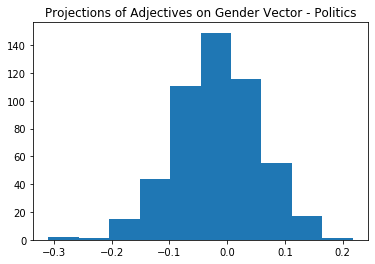

In [493]:
plt.hist(temp)
plt.title("Projections of Adjectives on Gender Vector - Politics")
plt.show()

In [499]:
len(list(filter(lambda x: x < tmean - tstd, temp)))

74

In [528]:
len(list(filter(lambda x: x > tmean + tstd, temp)))

209

In [521]:
len(list(filter(lambda x: x in mpol.wv.vocab, adjs_all)))

629

In [540]:
#run
num_adjs = 209

In [329]:
def get_adj_lists(m):
    temp = sorted([(x, gproj(getg(m), m, x)) for x in adjs_bias \
                   if x in m.wv.vocab], key=lambda x: x[1])
    return [x[0] for x in temp[:num_adjs]], \
           [x[0] for x in temp[len(temp)-num_adjs:]]

In [235]:
apol1, apol2 = get_adj_lists(mpol)
len(apol1), len(apol2)

(300, 300)

In [482]:
sorted([(x, gproj(getg(mpol), mpol, x), swn_score(x)) for x in apol2], \
       key=lambda x: x[1], reverse=True)[:5]

[('loyal', 0.21781564, 0.5),
 ('calm', 0.15803167, -0.375),
 ('admirable', 0.15252876, 0.75),
 ('charismatic', 0.14838041, 0.5),
 ('clumsy', 0.14027488, -0.125)]

In [483]:
sorted([(x, gproj(getg(mmov), mmov, x), swn_score(x)) for x in amov2], \
       key=lambda x: x[1], reverse=True)[:5]

[('direct', 0.24215876, -0.25),
 ('civil', 0.22271426, 0.125),
 ('questioning', 0.22204797, -0.125),
 ('independent', 0.20418105, 0.125),
 ('frank', 0.17268638, 0.125)]

In [486]:
sorted([(x, gproj(getg(mbooks), mbooks, x), swn_score(x)) for x in abooks2], \
       key=lambda x: x[1], reverse=True)[:5]

[('patriotic', 0.29985127, 0.125),
 ('liberal', 0.28159603, 0.625),
 ('grand', 0.22807221, 0.25),
 ('progressive', 0.22761683, 0.625),
 ('moderate', 0.22250967, -0.375)]

In [484]:
sorted([(x, gproj(getg(mmov), mmov, x), swn_score(x)) for x in amov1], \
       key=lambda x: x[1])[:5]

[('demure', -0.40574434, 0.5),
 ('fabulous', -0.40027168, 0.75),
 ('sexy', -0.38357872, 0.625),
 ('lovely', -0.34983596, 0.625),
 ('beautiful', -0.33718085, 0.75)]

In [485]:
sorted([(x, gproj(getg(mpol), mpol, x), swn_score(x)) for x in apol1], \
       key=lambda x: x[1])[:5]

[('patient', -0.3098677, 0.25),
 ('healthy', -0.2604588, 0.75),
 ('diligent', -0.22501096, 0.625),
 ('decent', -0.19484079, 0.875),
 ('lovely', -0.18960457, 0.625)]

In [489]:
sorted([(x, gproj(getg(mbooks), mbooks, x), swn_score(x)) for x in abooks1], \
       key=lambda x: x[1])[:5]

[('beautiful', -0.36147895, 0.75),
 ('sexy', -0.31237495, 0.625),
 ('glamorous', -0.28069398, 0.375),
 ('sensual', -0.26773366, 0.125),
 ('caring', -0.23501632, 0.25)]

In [ ]:
sorted([(x, swn_score(x)) for x in apol2], key=lambda x: x[1])[:5]

In [262]:
abooks1, abooks2 = get_adj_lists(mbooks)
len(abooks1), len(abooks2)

(300, 300)

In [263]:
amov1, amov2 = get_adj_lists(mmov)
len(amov1), len(amov2)

(300, 300)

In [268]:
def weighted_sb(m):
    a1, a2 = get_adj_lists(m)
    return sum([abs(gproj(getg(m), m, x))*swn_score(x) for x in a1]), \
           sum([abs(gproj(getg(m), m, x))*swn_score(x) for x in a2])

In [345]:
def get_gdir(m):
    h, s = gproj(getg(m), m, 'he'), gproj(getg(m), m, 'she')
    print(h, s)
    return h, s, (h+s)/2

In [270]:
def norm_sb(m):
    a1, a2 = get_adj_lists(m)
    h, s, hs = get_gdir(m)
    return sum([abs(gproj(getg(m), m, x)/s)*swn_score(x) for x in a1]), \
           sum([abs(gproj(getg(m), m, x)/h)*swn_score(x) for x in a2])

In [300]:
norm_sb(mpol), norm_sb(mbooks), norm_sb(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


((3.162538355216384, 1.4912605471909046),
 (3.3112002988010647, 4.077601205557585),
 (5.51348378136754, 5.36511062271893))

In [272]:
def scale_sb(m):
    a1, a2 = get_adj_lists(m)
    h, s, hs = get_gdir(m)
    return sum([abs(gproj(getg(m), m, x) - hs)*swn_score(x) for x in a1]), \
           sum([abs(gproj(getg(m), m, x) - hs)*swn_score(x) for x in a2])

In [261]:
scale_sb(mpol), scale_sb(mbooks), scale_sb(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


((1.7247874721918488, 0.6310292075386883),
 (0.14364903768710796, 1.4876473221679907),
 (1.4787104708887635, 2.0745052116617444))

In [223]:
hpol, spol, avgpol = get_gdir(mpol)
hbooks, sbooks, avgbooks = get_gdir(mbooks)
hmov, smov, avgmov = get_gdir(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


In [225]:
def swn_score(x):
    try:
        s = swn.senti_synset(x + ".a.01")
        return s.pos_score() - s.neg_score()
    except:
        return 0

In [227]:
def swn_bias(m):
    a1, a2 = get_adj_lists(m)
    return sum([swn_score(x) for x in a1]), sum([swn_score(x) for x in a2])

In [ ]:
#run

In [536]:
weighted_sb(mpol), weighted_sb(mbooks), weighted_sb(mmov)

((1.7336519272215665, 0.2859736363653269),
 (2.061730328530073, 0.593745810049586),
 (1.6817176950350405, 1.0290070636183373))

In [537]:
norm_sb(mpol), norm_sb(mbooks), norm_sb(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


((3.8354512557163836, 1.267158538839567),
 (4.141725453048945, 3.1926088630706073),
 (3.915770623087883, 5.573176347956178))

In [538]:
scale_sb(mpol), scale_sb(mbooks), scale_sb(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


((0.886271051492542, -0.2091150508012447),
 (0.789029377579689, 0.9314467736659573),
 (1.2545430466532705, 2.6077588960688445))

In [539]:
swn_bias(mpol), swn_bias(mbooks), swn_bias(mmov)

((13.506, -4.375), (11.237, 2.1660000000000004), (2.4030000000000005, 13.5))

In [376]:
weighted_sb(mpol), weighted_sb(mbooks), weighted_sb(mmov)

((1.3533039325848222, 0.29404603131115437),
 (1.7124517742097378, 0.6149269239977002),
 (2.0845603682100773, 0.7970253718085587))

In [353]:
norm_sb(mpol), norm_sb(mbooks), norm_sb(mmov)

0.22568104 -0.4520073
0.18597512 -0.49779502
0.18463565 -0.42947298


((3.2606441378593445, 1.7218275777995586),
 (3.284544779419899, 3.9604589119553566),
 (5.282709550112486, 5.394994001835585))

In [355]:
swn_bias(mpol), swn_bias(mbooks), swn_bias(mmov)

((8.375, 3.25), (6.862, 6.25), (7.75, 13.125))

In [240]:
swn_bias(mpol), swn_bias(mbooks), swn_bias(mmov)

((21.881, 3.875), (5.84, 5.666), (6.256, 7.25))

# WEAT

In [587]:
stereotypes_m = ['president', 'dean', \
                 'director', 'officer', 'manager', 'captain', 'coach', 'commissioner', 'sergeant', "principal", "programmer"]
stereotypes_f = ['teacher', 'author', 'secretary', 'writer', \
                 'editor', "nurse", "housekeeper", "maid", "dancer", "artist", "homemaker"]
male = ["male", "man", "brother", "he", "him", "son", "father", "boy", "masculine", "mr", "john"]
female = ["female", "woman", "sister", "she", "her", \
          "daughter", "mother", "girl", "feminine", "mrs", "mary"]
def cos_sim(m, x, y):
    wv1 = m.wv.get_vector(x)
    wv2 = m.wv.get_vector(y)
    sim = np.dot(wv1, wv2)/(np.linalg.norm(wv1)*np.linalg.norm(wv2))
    return sim
def cos_sim2(wv1, wv2):
    return np.dot(wv1, wv2)/(np.linalg.norm(wv1)*np.linalg.norm(wv2))
def s_word(m, w, A, B):
    return np.mean([cos_sim(m, w, a) for a in A]) - np.mean([cos_sim(m, w, b) for b in B])
def effect_size(m, X, Y, A, B):
    num = np.mean([s_word(m, x, A, B) for x in X]) - np.mean([s_word(m, y, A, B) for y in Y])
    return num/np.std([s_word(m, x, A, B) for x in X + Y])
def wbias(m, l, shuf):
    if shuf:
#         shuffle(stereotypes_m)
#         shuffle(stereotypes_f)
        shuffle(male)
        shuffle(female)
    return abs(effect_size(m, male[:l], female[:l], stereotypes_m, stereotypes_f))

# Training Word Embeddings

In [ ]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [138]:
t = time.process_time()
msports = getw2v(sports)
time.process_time() - t

84.06553399999939

In [137]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

208.07826299999942

In [139]:
t = time.process_time()
mmov = getw2v(movies)
time.process_time() - t

112.02558700000009

In [136]:
t = time.process_time()
mbooks = getw2v(books)
time.process_time() - t

118.6554789999991

In [ ]:
def bias(g, m, vocab, wordlist):
    b = 0
    l = list(filter(lambda x: x in vocab, wordlist))
    for x in l:
        b += abs(gproj(g, m, x))
    return b/len(l)